In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split 
np.random.seed(23)
from datetime import datetime

# the variable 'now' references the datetime that the data was saved. 
# Other notebooks call it to reference the most recent version of the cleaned data.
today = datetime.today()
now = today.strftime('%Y-%m-%d-%H-%M')
%store now

Stored 'now' (str)


## Data Preprocessing

### The data set with the genders of music artists

The file singers_gender.csv is from Kaggle and lists music artists and their gender: 

https://www.kaggle.com/rkibria/singersgender 

This csv file containing the name and gender of singers was used to scrape genre metadata for each artist from Wikipedia. It is stored in the csv file here: 

'./data/genre_lists/data_to_be_cleaned/wiki-kaggle_genres_rescrape.csv'

We verified the gender of the artists for a 1% sample.

### We next clean the data. This involves 
- removing artists for which no genre information was obtained
- removing bands (which do not have a singular gender)
- correcting spelling irregularities for names of genres (sometimes referred to as genre labels)
- normalizing and aggregating genres
- organizing genres into a list (in the csv this is a string, but in the data frame it is a list)

The 'cleaning' process also involved making calls about which genre labels should be considered spelling variants of a single genre. For example, 'rock n roll' and 'rock and roll' were aggregated into a single genre, but kept separate from 'rock'. The labels 'r & b' and 'r n b' were combined but kept separarte from 'rhythm and blues'.

In addition to cleaning the data, a new column is added with the number of genres for each artist.

Run the following commands to clean the scraped data and view the head.

In [2]:
from src.genre_scripts.genre_cleaning import clean_genre_data

In [3]:
data = clean_genre_data()

In [4]:
data.head()

,artist,gender,genrelist,genrelist_length
1,Christopher_Willits,male,"[electronic, glitch, ambient, electro_acoustic...",5
3,Shawn_Hook,male,"[pop, electronic, rock]",3
4,Steve_Poltz,male,"[pop_rock, indie_rock, folk_rock]",3
6,Marvin_Isley,male,"[r_and_b, funk, soul, funk_rock]",4
7,Povel_Ramel,male,[vaudeville],1


### Export the cleaned data set:

In [5]:
data.to_csv('./data/genre_lists/data_ready_for_model/wiki-kaggle_genres_gender_cleaned_{}.csv'.format(now))

### Extract the list of unique genres:

In [6]:
genre_list = data.genrelist.values.tolist()
genre_list = [x for y in genre_list for x in y]
genre_list = list(set(genre_list))
genre_list = sorted(genre_list)

### Export the list of genres:

In [7]:
genre_list_df = pd.DataFrame({'genre_list':genre_list})
genre_list_df.to_csv('./data/genre_lists/data_ready_for_model/genre_list_{}.csv'.format(now))

### Create the train test split

This train-test split will be used for ML modeling. 

In [8]:
data = pd.read_csv('./data/genre_lists/data_ready_for_model/wiki-kaggle_genres_gender_cleaned_{}.csv'.format(now), index_col = ['artist'])
data.drop(['Unnamed: 0'], axis = 1,  inplace = True)

X = data[['genrelist', 'genrelist_length']]
y = data.gender

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# # export for further use
X_train.to_csv('./data/genre_lists/data_ready_for_model/wiki-kaggle_X_train_{}.csv'.format(now))
y_train.to_csv('./data/genre_lists/data_ready_for_model/wiki-kaggle_y_train_{}.csv'.format(now))

X_test.to_csv('./data/genre_lists/data_ready_for_model/wiki-kaggle_X_test_{}.csv'.format(now))
y_test.to_csv('./data/genre_lists/data_ready_for_model/wiki-kaggle_y_test_{}.csv'.format(now))

## The basic shape of the data

Although in this notebook the DataFrame 'data' is already loaded, we reimport the data using the LoadDataClass as this is the method used in other notebooks and in the scripts. It also enables more functionality.

### Load the data

In [9]:
from src.genre_scripts.genre_data_loader import LoadGenreData

In [19]:
# get currrent date for latest version of data set
# %store -r now # not needed in this nb where 'now' is defined

X_path_train = './data/genre_lists/data_ready_for_model/wiki-kaggle_X_train_{}.csv'.format(now)
y_path_train = './data/genre_lists/data_ready_for_model/wiki-kaggle_y_train_{}.csv'.format(now)
X_path_test = './data/genre_lists/data_ready_for_model/wiki-kaggle_X_test_{}.csv'.format(now)
y_path_test = './data/genre_lists/data_ready_for_model/wiki-kaggle_y_test_{}.csv'.format(now)

In [24]:
# call data loader script
genre_data = LoadGenreData(now, X_path_train = X_path_train, y_path_train = y_path_train, 
                                             X_path_test = X_path_test, y_path_test = y_path_test)

data = genre_data.data
genre_list = genre_data.get_list_of_genres()

### Basic shape of the data

In [25]:
p_fem = genre_data.get_percent_female()
p_mal = genre_data.get_percent_male()
print(f'There are {data.shape[0]} artists with genre and binary-gender labels.')
print(f'{round(100*p_fem,1)}% are female artists.')
print(f'{round(100*p_mal,1)}% are male artists.')
print(f'There are {len(genre_list)} unique genre labels.')

There are 15470 artists with genre and binary-gender labels.
31.4% are female artists.
68.6% are male artists.
There are 1491 unique genre labels.


In [26]:
a,b,c = data.genrelist_length.mean(), data.genrelist_length.std(), data.genrelist_length.max()
print(f'Mean number of genre labels: {round(a,2)}.')
print(f'STD of the number of genre labels: {round(b,2)}.')
print(f'Max number of genre labels: {c}.')

Mean number of genre labels: 2.71.
STD of the number of genre labels: 1.8.
Max number of genre labels: 73.


### Take a look at the most frequent genres:

In [27]:
# import a UDF to create a DataFrame with the frequencies of genres
from src.genre_scripts.genre_frequency_by_gender import frequency_by_gender

In [28]:
genre_frequencies = frequency_by_gender(genre_data.get_sparse_X_vector(), data, genre_data.get_dict_id_to_genre())
# sort by frequences descending
genre_frequencies.sort_values(['frequency'], ascending = False, inplace = True)
genre_frequencies.set_index('genre', inplace = True)

In [29]:
genre_frequencies.head(10)

,frequency,female,male
genre,,,
pop,3279,1669,1610
rock,2208,461,1747
country,2026,634,1392
r_and_b,1926,940,986
hip_hop,1395,248,1147
soul,1304,676,628
folk,1283,530,753
jazz,1173,489,684
alternative_rock,1151,242,909


## Gender bias in the length of genre lists of artists

_How does the number of genres assigned to an artist depend on gender?_ In this section we'll see that male artists are over represented, and female artists under represented, among all artists with 5 or more genres. We aggregate the statistics on male and female artists for each bin. The counts for 11 or more genres are grouped together so that the $\chi^2$-test can be applied (using the requirement that the expected count in each cell of the contingency table should be at least 5). Furthermore, there are no female artists with 12 or more genres in the data set, a fact which is of interest in itself in the exploration of gender bias.

In [30]:
from src.genre_scripts.genre_list_length_bias import generate_bias_plots, p_value_chi_sq, bias_11_bins, bias_two_bins
lcbg_11_bin = bias_11_bins(data[['genrelist_length','gender','genrelist']], p_fem, p_mal)
lcbg_11_bin

,female artist count,male artist count,total,female artist expected,male artist expected,female bias,male bias
genre list length,,,,,,,
1,1306,3149,4455,1398.127020,3056.872980,0.934107,1.030138
2,1299,2521,3820,1198.842922,2621.157078,1.083545,0.961789
3,1072,2043,3115,977.590498,2137.409502,1.096574,0.955830
4,629,1367,1996,626.411118,1369.588882,1.004133,0.998110
5,305,755,1060,332.663219,727.336781,0.916843,1.038034
6,155,410,565,177.315772,387.684228,0.874147,1.057562
7,49,189,238,74.692308,163.307692,0.656025,1.157325
8,20,99,119,37.346154,81.653846,0.535530,1.212435
9,10,39,49,15.377828,33.622172,0.650287,1.159949


## 11 Bins

Using a $\chi^2$-test we calculate the $p$-value for the observed counts vs. the expected counts.

In [31]:
p_value = p_value_chi_sq(lcbg_11_bin, 11)
f"The p-value of {round(p_value,13)}, much smaller than 1%, shows that this empirical distribution of male and \
female genre list lengths is highly improbable. We conclude that there is a correlation between gender and genre \
list length."

'The p-value of 1e-11, much smaller than 1%, shows that this empirical distribution of male and female genre list lengths is highly improbable. We conclude that there is a correlation between gender and genre list length.'

To visualize the bias, we claculate the following ratios. For each bin (either an integer or a range of integers), calculate
$$\frac{\text{actual # of male artists in bin}}{\text{expected # of male artists in bin}}$$
where the expected number of male artists in a bin is ${\% \text{male in total sample} \cdot \text{total in bin}}$. The same ratio is calculated for female artists. If the number of genres and gender did not correlate, we would expect the ratios to be close to one. 

We plot the values:

In [32]:
fig_11_bins, fig_paths, fig_means, fig_means_select = generate_bias_plots(now)

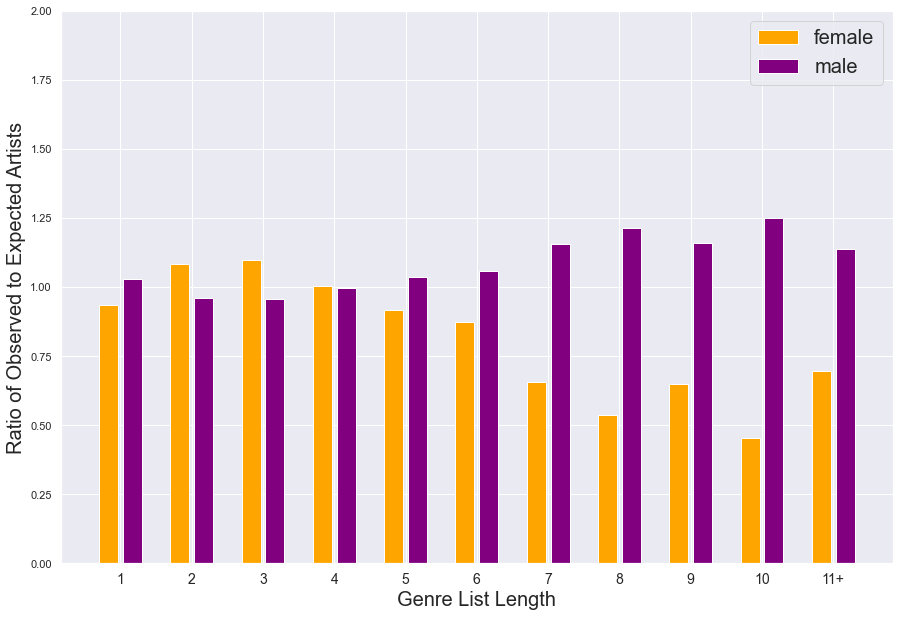

In [33]:
fig_11_bins

### Two Bins

A more succint but less detailed picture arises by aggregating into just two bins. Split the genre lists into two bins: those with length $\leq 5$ and those with length $\geq 6$. For each bin, calculate

$$\frac{\text{actual # of male artists in bin}}{\text{expected # of male artists in bin}}$$

where the expected number of male artists in a bin is ${(\% \text{male in total sample)} \cdot \text{(total in bin)}}$. Do the same for female artists. This gives another measure of bias. 

We find that for genre list lengths $\leq 5$, the ratio is close to $1$ for male and female artists. However, for list lengths $\geq 6$, male artists are over represented and female artists are under represented.


In [34]:
lcbg_two_bins = bias_two_bins(data[['genrelist_length','gender','genrelist']], p_fem, p_mal)
lcbg_two_bins

,female artist count,male artist count,total,female artist expected,male artist expected,female bias,male bias
classify,,,,,,,
1-5,4611,9835,14446,4533.634777,9912.365223,1.017065,0.992195
>5,244,780,1024,321.365223,702.634777,0.759261,1.110107


Using a $\chi^2$-test we calculate the $p$-value for the observed counts vs. the expected counts.

In [35]:
p_value = p_value_chi_sq(lcbg_two_bins, 2)
f"The p-value of {round(p_value,9)}, much smaller than 1%, shows that this empirical distribution of male and \
female genre list lengths is highly improbable. We conclude that there is a correlation between gender and genre \
list length."

'The p-value of 7e-08, much smaller than 1%, shows that this empirical distribution of male and female genre list lengths is highly improbable. We conclude that there is a correlation between gender and genre list length.'

The figure below shows the bias for females and males in the two categories defined above. The first measures gender bias for artists with $\leq 5$ genres for a) the mean over 100 random subsamples of size 4648 and b) the whole data set. In this case, there is extremely little bias.

The second measures gender bias for artists with $\geq 6$ genres for a) the mean over 100 random subsamples of size 4648 and b) the whole data set. In this case, there is significant bias: .8 for females (under represented) and 1.1 for males (over represented). The mean bias over 100 random subsets of size 4648 (~30% of the full sample) is close to that calculated over the full sample. This suggests that if we were to collect a larger sample the level of bias would remain stable. 

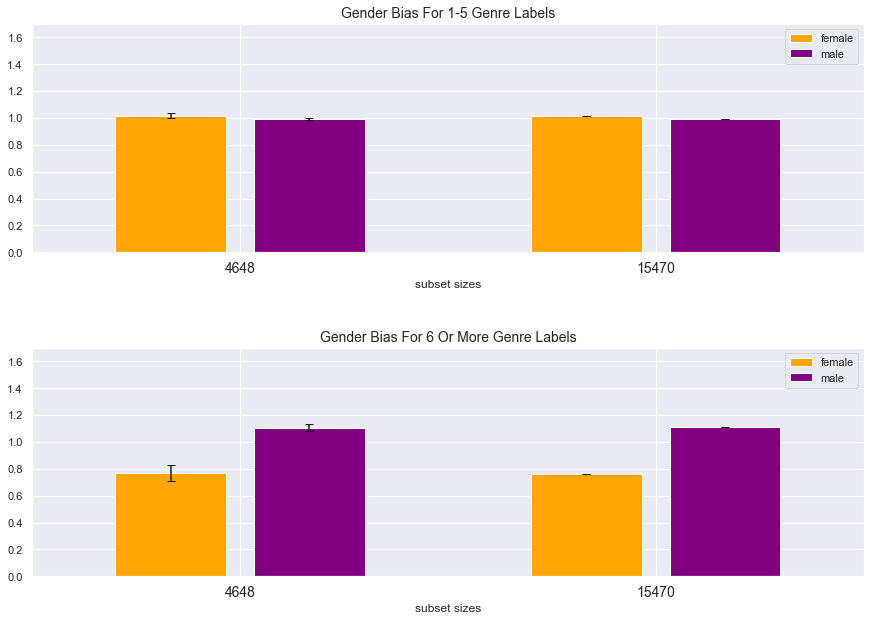

In [36]:
fig_means_select

The next figure looks at how the bias varies with the size of the subsample in more depth. 100 random nested subsamples (whose sizes are labeled on the x-axis) were generated and the mean and standard deviation of the bias were calculated for each size. We see that the mean bias stabalizes before the subset is even half the size of the full data set. 

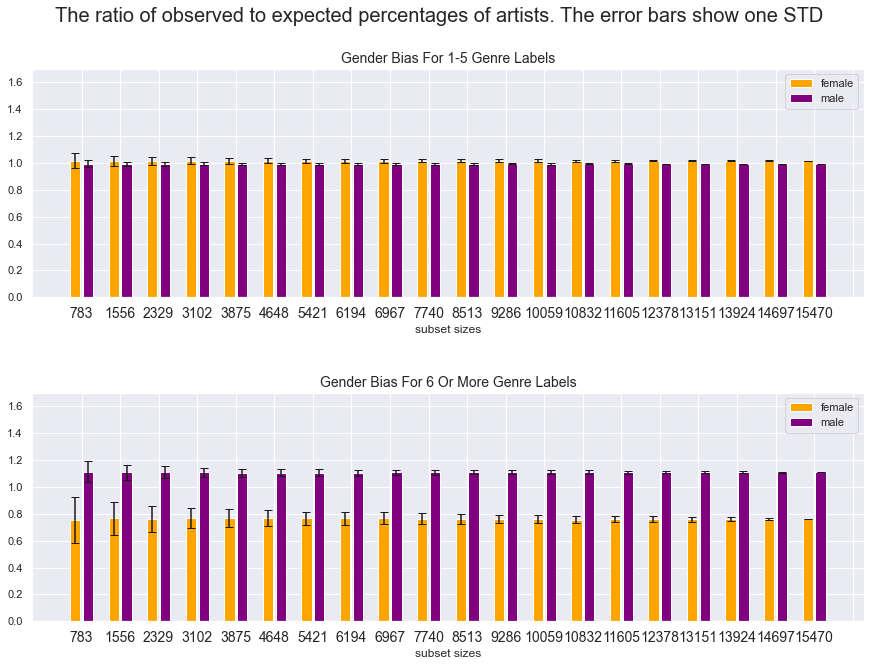

In [37]:
fig_means

The next figure plots the bias for each of the 100 nested subsets: each path shows the bias for a particular sequence of nested subsets. The significance of the geometry of the paths is 1) that the bias with $\geq 6$ labels is safely away from 1.0 even when less than half of the data is used and 2) that the paths oscillate around a line of zero slope. If they oscillated around a curve that had non-zero slope at the full data set (right hand side of the plot), that would have suggested that the data had not captured the full distribution. The convergence of all paths to the same point is of no significance: at size 15470 all paths use the full data set.

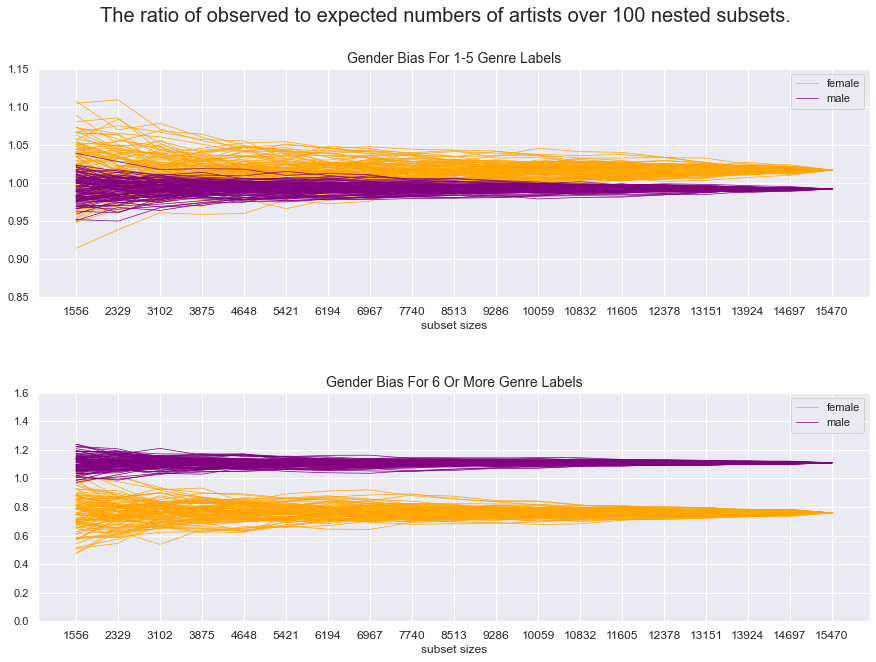

In [38]:
fig_paths

## Limits of predictive modeling

Given any input, a model that always predicts male will be correct 69% of the time as that is the percentage of males in the sample. A model using a majority vote for each genre-set that appears has an in-sample accuracy of 86%. This is an upper bound for the full in-sample accuracy of any model. On subsets, such as a validation or test set, the upper bound is higher.

![Upper Bound to Accuracy](./visualizations/upperbound_curves.png)

When evaluating the accuracy of any model, its accuracy should be compared to 86%. If a model scores P%, then P/86 is a measure of how close the model is to the optimal model.

Calculate the mean upper bound on subsamples of size 2000 over 100 different subsamples:

In [39]:
from src.genre_scripts.genre_upperbound import UpperBound
uppers_2000 = []
data = genre_data.as_sets() # create a column in data with the genres for each artists as sets
for i in range(100):
    subsample = data.sample(2000)
    set_counts, error = UpperBound(subsample)
    uppers_2000.append(1 - error)
uppers_2000 = np.array(uppers_2000)
print(f'The mean upperbound is {np.mean(uppers_2000)}.')

The mean upperbound is 0.89985.


### Summary



We have shown that in this data set of 15470 music artists, there is a significant correlation between the number of genres assigned to an artist and their gender. In particular, male artists are more likely than female artists to have 6 or more genre labels assigned to them.

We also show that there is a nontrivial upper bound for the accuracy of any model that tries to predict gender based on the genre labels of an artist. On the full sample the bound is 86%; on subsamples of size 2000 the expected value of the upper bound is 90%.